## Simulating an IA that learns incrementally
An IA can incrementally gain experience and improve performance much like a human agent. In this process of a call center answering user questions, the topic of the question can be determined by an **IA** based on the user click stream data.

The *resource characteristics* of the IA is the **performance** that improves with time as the agent *learns* with more information from data

The **experience** of the agent further increases


In [63]:
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams


from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

In [64]:
#read the csv file and create a dataframe

train_data = pd.read_csv("resources/question_click_def.csv", sep=",")
train_data['date'] = pd.to_datetime(train_data['date'])
all_classes = train_data['qtheme'].unique()

train_data = train_data[train_data.qtheme != 41]
train_data.head(5)
#print(all_classes)

,sessionID,page_name,customerID,ageCategory,gender,date,qtheme,qsubtheme,qtopic
37,2138613,vacatures_bij_mijn_cv,2020534,50-65,V,2015-09-02,26951,10293,27329
187,18573034,vacatures_bij_mijn_cv,1789218,30-39,M,2015-07-06,25658,25469,25468
188,18573034,vacatures_bij_mijn_cv,1789218,30-39,M,2015-07-06,25658,25469,25468
189,18573034,vacatures_bij_mijn_cv,1789218,30-39,M,2015-07-06,25658,25469,25468
190,18573034,vacatures_bij_mijn_cv,1789218,30-39,M,2015-07-06,25658,25469,25468


### Extracting relevant information from event log (features) 
Transform the event log using the one-hot encoding and aggregating session clicks for each customer and session. 

In [65]:
def transform(X, col_names, label_col):
        
   # transform cat cols
    dt_transformed = pd.get_dummies(X[col_names])
    dt_transformed['sessionID'] = X['sessionID']
    dt_label = X.groupby('sessionID').first()[label_col]
    del X
    dt_transformed = dt_transformed.groupby('sessionID').sum()
    
    dt_transformed = dt_transformed.fillna(0)
    #print(dt_transformed)
    return dt_transformed, dt_label
    

### Chunking the data based on time to reflect new data processed by IA
We first split the data multiple chunks. The last chunk is used as a **unseen data** and the remaining are incrementally added to train the classifier.


The **unseen data** is used later to present an **online** scenario where the agent characteristics would be used to decide the level of automation.

(964, 7)
0 (100, 7) (100,)
1 (100, 7) (100,)
2 (100, 7) (100,)
3 (100, 7) (100,)
4 (100, 7) (100,)
5 (100, 7) (100,)
6 (100, 7) (100,)
7 (100, 7) (100,)
8 (100, 7) (100,)
9 (64, 7) (64,)


(array([0.00013616, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00010147, 0.00011808]),
 array([   31. ,  2842.3,  5653.6,  8464.9, 11276.2, 14087.5, 16898.8,
        19710.1, 22521.4, 25332.7, 28144. ]),
 <a list of 10 Patch objects>)

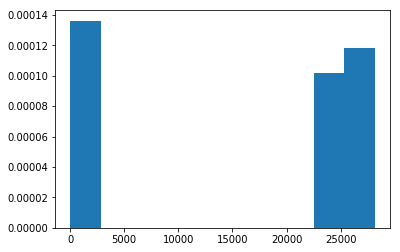

In [67]:
import collections

dt_x, dt_y = transform(train_data, ['page_name', 'ageCategory', 'gender'], 'qtheme')
print(dt_x.shape)

data_xdict = dict()
for g, df in dt_x.groupby(np.arange(len(dt_x)) // 100):
    data_xdict[g]=df

data_ydict = dict()
for g, df in dt_y.groupby(np.arange(len(dt_y)) // 100):
    data_ydict[g]=df

for key in data_xdict.keys():
    print(key, data_xdict[key].shape, data_ydict[key].shape)
    
#print(data)
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

ax.hist(dt_y, density=True)

### Prepare the data for the machine learning classifier


In [68]:
partial_fit_classifiers = {
    'Perceptron': Perceptron()
}

### Train the machine learning model
1. The data is split into train and test 
2. First hyper parameter tuning is done using grid search and cross validation (4-fold)
3. The classifier performance is evaluated on the test set

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

num_batches = len(data_xdict)-2
print(num_batches)
accuracy_dict=dict()

X_test = data_xdict[num_batches-1]
y_test = data_ydict[num_batches-1]

total_vect_time=0

for i in range(0,num_batches):

    tick = time.time()
    X_train = data_xdict[i]
    y_train = data_ydict[i]
    
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        
        pred =  cls.predict(X_test)
        print(classification_report(y_test, pred))
        accuracy = accuracy_score(y_test, pred)
        if cls_name in accuracy_dict:
            lst = accuracy_dict[cls_name]
            lst.append(accuracy)
            accuracy_dict[cls_name]= lst
        else:
            accuracy_dict[cls_name]=[accuracy]
        print( 'accuracy of ', cls_name, ' in iteration ', i , " = ", accuracy)




8
              precision    recall  f1-score   support

          31       0.38      0.44      0.41        32
          45       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         8
       22619       0.00      0.00      0.00         1
       23066       0.00      0.00      0.00        15
       23116       0.04      0.40      0.08         5
       25658       0.00      0.00      0.00        21
       25659       0.00      0.00      0.00         4
       26951       0.00      0.00      0.00        13

    accuracy                           0.16       100
   macro avg       0.05      0.09      0.05       100
weighted avg       0.12      0.16      0.13       100

accuracy of  Perceptron  in iteration  0  =  0.16
              precision    recall  f1-score   support

          31       0.46      0.41      0.43        32
          44       0.00      0.00      0.00         0
          45       0.00      0.00      0.00         1
          51       0.08   

C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\conda\anaconda3\lib\site-packages\skl

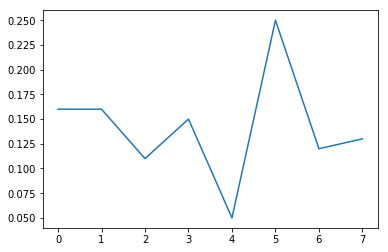

In [71]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

for cls_name in accuracy_dict.keys():
    ax.plot(accuracy_dict[cls_name]);

### Evaluating resource characteristic on unseen data
